In [0]:
import sys, os, re, csv, codecs
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.layers import Input, LSTM, Embedding, Lambda
# from keras.layers import Bidirectional, GlobalMaxPool1D
from keras.models import Model
from keras import initializers, regularizers, constraints, optimizers, layers
import keras.backend as K
from keras.optimizers import Adadelta
from keras.callbacks import ModelCheckpoint

Using TensorFlow backend.


In [0]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/drive


In [0]:
df_train = pd.read_csv('/content/drive/My Drive/Datasets/quora-question-pairs/train.csv')
df_test = pd.read_csv('/content/drive/My Drive/Datasets/quora-question-pairs/test.csv')
# df_test1 = pd.read_csv('/content/drive/My Drive/Datasets/quora-question-pairs/testquestions/OwnTrainingData.csv', \
#                        names=['question1', 'question2', 'is_duplicate'], header=None)

/usr/local/lib/python3.6/dist-packages/IPython/core/interactiveshell.py:2718: DtypeWarning: Columns (0) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [0]:
def text_to_word_list(text):
    ''' 
    Pre process and convert texts to a list of words 
    input: str
    output: list of cleaned word
    '''
    
    text = str(text)
    text = text.lower()

    # Clean the text
    text = re.sub(r"[^A-Za-z0-9^,!.\/'+-=]", " ", text)
    text = re.sub(r"what's", "what is ", text)
    text = re.sub(r"\'s", " ", text)
    text = re.sub(r"\'ve", " have ", text)
    text = re.sub(r"can't", "cannot ", text)
    text = re.sub(r"n't", " not ", text)
    text = re.sub(r"i'm", "i am ", text)
    text = re.sub(r"\'re", " are ", text)
    text = re.sub(r"\'d", " would ", text)
    text = re.sub(r"\'ll", " will ", text)
    text = re.sub(r",", " ", text)
    text = re.sub(r"\.", " ", text)
    text = re.sub(r"!", " ! ", text)
    text = re.sub(r"\/", " ", text)
    text = re.sub(r"\^", " ^ ", text)
    text = re.sub(r"\+", " + ", text)
    text = re.sub(r"\-", " - ", text)
    text = re.sub(r"\=", " = ", text)
    text = re.sub(r"'", " ", text)
    text = re.sub(r"(\d+)(k)", r"\g<1>000", text)
    text = re.sub(r":", " : ", text)
    text = re.sub(r" e g ", " eg ", text)
    text = re.sub(r" b g ", " bg ", text)
    text = re.sub(r" u s ", " american ", text)
    text = re.sub(r"\0s", "0", text)
    text = re.sub(r" 9 11 ", "911", text)
    text = re.sub(r"e - mail", "email", text)
    text = re.sub(r"j k", "jk", text)
    text = re.sub(r"\s{2,}", " ", text)
    text = re.sub("quikly","quickly", text)

    text = text.split()

    return text

In [0]:
list_sentences_train_q1 = df_train["question1"]
list_sentences_train_q2 = df_train["question2"]
list_sentences_test_q1 = df_test["question1"]
list_sentences_test_q2 = df_test["question2"]
list_sentences_test1_q1 = df_test1["question1"]
list_sentences_test1_q2 = df_test1["question2"]

In [0]:
# Cleaning the text
cleaned_train_q1 = []
cleaned_train_q2 = []
cleaned_test_q1 = []
cleaned_test_q2 = []
# cleaned_test1_q1 = []
# cleaned_test1_q2 = []

for q in list(list_sentences_train_q1):
    q_words = text_to_word_list(q)
    cleaned_train_q1.append(" ".join(q_words))
    
for q in list(list_sentences_train_q2):
    q_words = text_to_word_list(q)
    cleaned_train_q2.append(" ".join(q_words))

for q in list(list_sentences_test_q1):
    q_words = text_to_word_list(q)
    cleaned_test_q1.append(" ".join(q_words))
    
for q in list(list_sentences_test_q2):
    q_words = text_to_word_list(q)
    cleaned_test_q2.append(" ".join(q_words))

# for q in list(list_sentences_test1_q1):
#     q_words = text_to_word_list(q)
#     cleaned_test1_q1.append(" ".join(q_words))
    
# for q in list(list_sentences_test1_q2):
#     q_words = text_to_word_list(q)
#     cleaned_test1_q2.append(" ".join(q_words))

In [0]:
del list_sentences_test1_q1
del list_sentences_test1_q2
del list_sentences_test_q1
del list_sentences_test_q2
del list_sentences_train_q1
del list_sentences_train_q2

In [0]:
# Tokenize the text
max_features = 2000
tokenizer = Tokenizer(num_words=max_features)
tokenizer.fit_on_texts(cleaned_train_q1+cleaned_train_q2)
list_tokenized_train_q1 = tokenizer.texts_to_sequences(cleaned_train_q1)
list_tokenized_train_q2 = tokenizer.texts_to_sequences(cleaned_train_q2)
list_tokenized_test_q1 = tokenizer.texts_to_sequences(cleaned_test_q1)
list_tokenized_test_q2 = tokenizer.texts_to_sequences(cleaned_test_q2)
list_tokenized_test1_q1 = tokenizer.texts_to_sequences(cleaned_test1_q1)
list_tokenized_test1_q2 = tokenizer.texts_to_sequences(cleaned_test1_q2)

In [0]:
import itertools
from sklearn.model_selection import train_test_split
maxlen = 25 # Restricting the Maximum length of a question to 25 to reduce the training time from 20 mins to 6-7 mins

X = pd.DataFrame({'question1':list(list_tokenized_train_q1), 'question2':list(list_tokenized_train_q2)})
Y = df_train["is_duplicate"]
X_test = pd.DataFrame({'question1':list(list_tokenized_test_q1), 'question2':list(list_tokenized_test_q2)})
# X_test1 = pd.DataFrame({'question1':list(list_tokenized_test1_q1), 'question2':list(list_tokenized_test1_q2)})
# Y_test1 = df_test1["is_duplicate"]

# train test split x and y into train and validation
X_train, X_validation, Y_train, Y_validation = train_test_split(X,Y,test_size = 0.1)

# Split to dicts
X_test = {'left':X_test.question1,'right':X_test.question2}
# X_test1 = {'left':X_test1.question1,'right':X_test1.question2}
X_train = {'left':X_train.question1,'right':X_train.question2}
X_validation = {'left':X_validation.question1,'right':X_validation.question2}
#X_test = {'left':X_test.question1,'right':X_test.question2}

# fetch Ys
Y_train = Y_train.values
# Y_test1 = Y_test1.values
Y_validation = Y_validation.values

# zero padding
for dataset, side in itertools.product([X_test, X_test1, X_train, X_validation],['left','right']):
  dataset[side] = pad_sequences(dataset[side], maxlen = maxlen)

# Make sure everything is ok
assert X_train['left'].shape == X_train['right'].shape
assert len(X_train['left']) == len(Y_train)

In [0]:
type(X_train['left'][1])

numpy.ndarray

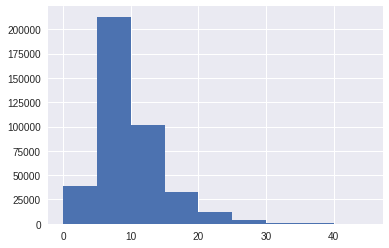

In [0]:
totalNumWords = [len(one_comment) for one_comment in list_tokenized_train_q1]
plt.hist(totalNumWords, bins = np.arange(0,50,5))
plt.show()

In [0]:
n_hidden = 50
gradient_clipping_norm  = 1.25
# what is gradient clipping norm?
# https://www.quora.com/What-is-gradient-clipping-and-why-is-it-necessary

batch_size = 64
n_epoch = 25

def exponent_neg_manhattan_distance(left, right):
  return K.exp(-K.sum(K.abs(left-right),axis = 1, keepdims = True))

# Input layer
left_input = Input(shape=(maxlen,), dtype="int32")
right_input = Input(shape=(maxlen,), dtype="int32")

# Embedding layer
# Not using a pretrained Embedding but training the embedding in the model itself
embed_size = 128
embedding_layer = Embedding(max_features, embed_size)

encoded_left = embedding_layer(left_input)
encoded_right = embedding_layer(right_input)

# LSTM layer
shared_lstm = LSTM(n_hidden)
left_output = shared_lstm(encoded_left)
right_output = shared_lstm(encoded_right)

malstm_distance = Lambda(function = lambda x:exponent_neg_manhattan_distance(x[0],x[1]),\
                         output_shape=lambda x: (x[0][0], 1))([left_output, right_output])

malstm = Model([left_input, right_input], [malstm_distance])
malstm.summary()

Instructions for updating:
Colocations handled automatically by placer.
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 25)           0                                            
__________________________________________________________________________________________________
input_2 (InputLayer)            (None, 25)           0                                            
__________________________________________________________________________________________________
embedding_1 (Embedding)         (None, 25, 128)      256000      input_1[0][0]                    
                                                                 input_2[0][0]                    
__________________________________________________________________________________________________
lstm_1 (LSTM)                   (None

In [0]:
optimizer = Adadelta(clipnorm = gradient_clipping_norm)

In [0]:
malstm.load_weights('weights.hdf5')
malstm.compile(loss='mean_squared_error', optimizer=optimizer, metrics=['accuracy'])

filepath="weights.hdf5"
checkpoint = ModelCheckpoint(filepath, monitor='val_acc', verbose=1, mode='max')
callbacks_list = [checkpoint]

malstm_trained = malstm.fit([X_train['left'], X_train['right']], Y_train, batch_size=batch_size, nb_epoch=5,\
                            validation_data=([X_validation['left'], X_validation['right']], Y_validation), callbacks=callbacks_list)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:8: UserWarning: The `nb_epoch` argument in `fit` has been renamed `epochs`.
  


Train on 363861 samples, validate on 40429 samples
Epoch 1/5
363861/363861 [==============================] - 364s 1ms/step - loss: 0.1403 - acc: 0.8183 - val_loss: 0.1451 - val_acc: 0.8101

Epoch 00001: saving model to weights.hdf5
Epoch 2/5
363861/363861 [==============================] - 363s 998us/step - loss: 0.1396 - acc: 0.8194 - val_loss: 0.1453 - val_acc: 0.8043

Epoch 00002: saving model to weights.hdf5
Epoch 3/5
363861/363861 [==============================] - 364s 1ms/step - loss: 0.1389 - acc: 0.8206 - val_loss: 0.1451 - val_acc: 0.8078

Epoch 00003: saving model to weights.hdf5
Epoch 4/5
363861/363861 [==============================] - 362s 995us/step - loss: 0.1382 - acc: 0.8219 - val_loss: 0.1457 - val_acc: 0.8068

Epoch 00004: saving model to weights.hdf5
Epoch 5/5
363861/363861 [==============================] - 364s 1000us/step - loss: 0.1375 - acc: 0.8232 - val_loss: 0.1455 - val_acc: 0.8060

Epoch 00005: saving model to weights.hdf5


In [0]:
malstm.save_weights("weights_v2.h5")

In [0]:
malstm.save("saved_model_v2.h5")

In [0]:
from keras.models import load_model

def exponent_neg_manhattan_distance(left, right):
  return K.exp(-K.sum(K.abs(left-right),axis = 1, keepdims = True))

model_v2 = load_model("saved_model_v2.h5", custom_objects={'exponent_neg_manhattan_distance':exponent_neg_manhattan_distance})
model_v2.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 25)           0                                            
__________________________________________________________________________________________________
input_2 (InputLayer)            (None, 25)           0                                            
__________________________________________________________________________________________________
embedding_1 (Embedding)         (None, 25, 128)      256000      input_1[0][0]                    
                                                                 input_2[0][0]                    
__________________________________________________________________________________________________
lstm_1 (LSTM)                   (None, 50)           35800       embedding_1[0][0]                
          

In [0]:
Y_pred = model_v2.predict([X_validation['left'][:10], X_validation['right'][:10]])
y_classes = Y_pred.argmax(axis=-1)
y_classes

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0])

In [0]:
# from sklearn.metrics import accuracy_score
# print(accuracy_score(Y_test1, Y_pred))
def test_on_example(q1, q2):
    cleaned_q1 = []
    cleaned_q2 = []
    q1 = [q1]
    q2 = [q2]
    for q in list(q1):
        q1_words = text_to_word_list(q)
        cleaned_q1.append(" ".join(q1_words))
    
    for q in list(q2):
        q2_words = text_to_word_list(q)
        cleaned_q2.append(" ".join(q2_words))
        
    tokenized_q1 = tokenizer.texts_to_sequences(cleaned_q1)
    tokenized_q2 = tokenizer.texts_to_sequences(cleaned_q2)
    
    to_test = pd.DataFrame({'question1':list(tokenized_q1), 'question2':list(tokenized_q2)})
    
    X_to_test = {'left':to_test.question1,'right':to_test.question2}
    # zero padding
    for dataset, side in itertools.product([X_to_test],['left','right']):
        dataset[side] = pad_sequences(dataset[side], maxlen = maxlen)

    score = model_v2.predict([X_to_test["left"], X_to_test["right"]])
    for s in score:
        if s >= 0.5:
            print("The sentences are same\nConfidence = ","{:.4f}".format(s[0]))
        else:
            print("The sentences are different\nConfidence = ","{:.4f}".format(s[0]))

In [0]:
test_on_example("How do I read and find my YouTube comments?","How can I see all my Youtube comments?")

The sentences are same
Confidence =  0.8104


In [0]:
import pickle
tokenizer_file = open("tokenizer","wb")
pickle.dump(tokenizer, tokenizer_file)
tokenizer_file.close()